<a href="https://colab.research.google.com/github/Thien-Nhan-28/Essay/blob/main/DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. Kết nối với Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd '/content/gdrive/MyDrive/Essay'


Mounted at /content/gdrive
/content/gdrive/MyDrive/Essay


In [ ]:
pip install tensorflow


### 2. Import thư viện

In [ ]:
import pandas as pd
import glob2
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

### 3. Đọc dữ liệu và gán nhãn

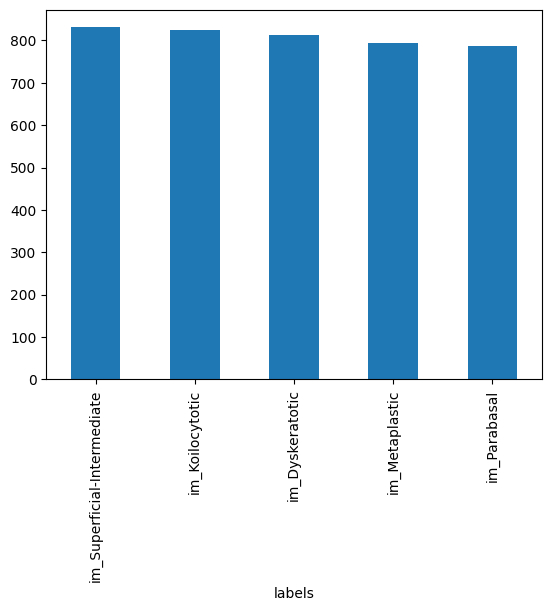

labels
im_Superficial-Intermediate    831
im_Koilocytotic                825
im_Dyskeratotic                813
im_Metaplastic                 793
im_Parabasal                   787
Name: count, dtype: int64


In [ ]:
# Danh sách các lớp
classes = ["im_Dyskeratotic", "im_Koilocytotic", "im_Metaplastic",
           "im_Parabasal", "im_Superficial-Intermediate"]

labels = []
image_links = []
class_path = '/content/gdrive/MyDrive/Essay'

# Load tất cả ảnh và gán nhãn tương ứng
for class_name in classes:
    images = glob2.glob(f'{class_path}/{class_name}/{class_name}/CROPPED/*.bmp')
    labels.extend([class_name] * len(images))
    image_links.extend(images)

# Chuyển dữ liệu vào DataFrame để tiện xử lý
data = pd.DataFrame({'labels': labels, 'image_links': image_links})

# Kiểm tra số lượng ảnh trên mỗi lớp
data['labels'].value_counts().plot.bar()
plt.show()
print(data['labels'].value_counts())


### 4. Chia tập dữ liệu

In [ ]:
# Chia tập test trước (15%)
images_train_val, images_test, y_train_val, y_test = train_test_split(
    image_links, labels, stratify=labels, test_size=0.15, random_state=42
)

print(f'Train + Val: {len(images_train_val)}, Test: {len(images_test)}')
 # Chia tập train và validation từ tập train_val
images_train, images_val, y_train, y_val = train_test_split(
    images_train_val, y_train_val, stratify=y_train_val, test_size=0.176, random_state=42
)  # 0.176 * 85% = 15%

print(f'Train: {len(images_train)}, Val: {len(images_val)}, Test: {len(images_test)}')


Train + Val: 3441, Test: 608
Train: 2835, Val: 606, Test: 608


### 5. Chuẩn hóa hình ảnh

In [ ]:
def load_and_resize_image(img_path, target_size=(224, 224)):
    img = cv2.imread(img_path)  # Đọc ảnh
    if img is None:
        print(f"Error reading image: {img_path}")
        return None
    img_resized = cv2.resize(img, target_size)  # Resize ảnh
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)  # Đổi sang RGB (OpenCV đọc theo BGR)
    img_normalized = img_rgb / 255.0
    return img_normalized

# Kiểm tra và đảm bảo rằng tất cả ảnh đều đúng kích thước
for img_path in image_links:
    img = load_and_resize_image(img_path)
    if img is not None:
        # In ra kích thước ảnh đã được xử lý
        print(f"Processed image shape for {img_path}: {img.shape}")
        if img.shape != (224, 224, 3):
            print(f"Unexpected shape for {img_path}: {img.shape}")


Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/111_06.bmp: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/112_03.bmp: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/111_04.bmp: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/111_02.bmp: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/113_03.bmp: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/114_11.bmp: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/113_02.bmp: (224, 224, 3)
Processed image shape for /content/gdrive/MyDrive/Essay/im_Dyskeratotic/im_Dyskeratotic/CROPPED/114_02.bmp: (224, 224, 3)
Processed image shape fo

In [ ]:
# Khởi tạo ImageDataGenerator cho tập huấn luyện với tăng cường dữ liệu
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  # Chuẩn hóa cho DenseNet121
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Khởi tạo ImageDataGenerator cho tập kiểm tra (không tăng cường)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Khởi tạo ImageDataGenerator cho tập test (không tăng cường)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [ ]:
# Khởi tạo LabelEncoder
encoder = LabelEncoder()

# Chuyển đổi nhãn thành số cho tập huấn luyện và validation
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded = encoder.transform(y_val)

# Chuyển đổi nhãn sang dạng one-hot cho tập huấn luyện và validation
y_train_onehot = to_categorical(y_train_encoded, num_classes=5)
y_val_onehot = to_categorical(y_val_encoded, num_classes=5)

# Chuyển đổi nhãn thành số cho tập test (không cần one-hot)
y_test_encoded = encoder.transform(y_test)  # Đảm bảo bạn đã có biến y_test


In [ ]:
# Tạo generators cho tập huấn luyện
train_generator = train_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_links': images_train, 'labels': y_train}),
    x_col='image_links',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'  # Giữ nguyên nhãn ở dạng string
)

# Tạo generators cho tập kiểm tra
val_generator = val_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_links': images_val, 'labels': y_val}),
    x_col='image_links',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'image_links': images_test, 'labels': y_test}),
    x_col='image_links',
    y_col='labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Giữ nguyên thứ tự để đánh giá
)


Found 2835 validated image filenames belonging to 5 classes.
Found 606 validated image filenames belonging to 5 classes.
Found 608 validated image filenames belonging to 5 classes.


In [ ]:
# Kiểm tra kích thước của một vài ảnh trong tập huấn luyện
for i in range(5):  # Kiểm tra 5 ảnh đầu tiên
    img = load_and_resize_image(images_train[i])
    if img is not None:
        print(f"Image {i} shape: {img.shape}")  # Kỳ vọng (224, 224, 3)

# Lấy một batch từ train_generator và kiểm tra kích thước
batch_images, batch_labels = next(train_generator)
print(f'Batch image shape: {batch_images.shape}')  # Kỳ vọng (32, 224, 224, 3)
print(f'Batch label shape: {batch_labels.shape}')  # Kỳ vọng (32, 5)


Image 0 shape: (224, 224, 3)
Image 1 shape: (224, 224, 3)
Image 2 shape: (224, 224, 3)
Image 3 shape: (224, 224, 3)
Image 4 shape: (224, 224, 3)
Batch image shape: (32, 224, 224, 3)
Batch label shape: (32, 5)


### 6. Trích xuất đặc trưng bằng DenseNet121
1.   Khởi tạo mô hình
2.   Xây dựng mô hình
3.   pre-trained mô hình
4.   Fine-tune mô hình



In [ ]:
base_network = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Đặt các lớp ban đầu của DenseNet121 không thể huấn luyện
for layer in base_network.layers:
    layer.trainable = False  # Freeze tất cả các lớp

# Xây dựng mô hình
model = Sequential([
    base_network,
    GlobalAveragePooling2D(),              # Global Average Pooling
    Dropout(0.5),                          # Dropout để giảm overfitting
    Dense(64, activation='relu'),          # Lớp ẩn
    BatchNormalization(),                  # BatchNormalization để tối ưu hóa
    Dropout(0.5),                          # Dropout thêm một lần nữa
    Dense(5, activation='softmax')         # Lớp đầu ra với 5 lớp
])

# Biên dịch mô hình với optimizer
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
model.build((None, 224, 224, 3))
model.summary()


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │          65,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,103,685 (27.10 MB)

 Trainable params: 66,053 (258.02 KB)

 Non-trainable params: 7,037,632 (26.85 MB)

In [ ]:
model.fit(train_generator, epochs=10, validation_data=val_generator)


Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


89/89 ━━━━━━━━━━━━━━━━━━━━ 629s 7s/step - accuracy: 0.4015 - loss: 1.7909 - val_accuracy: 0.8482 - val_loss: 0.5021
Epoch 2/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 640s 7s/step - accuracy: 0.7251 - loss: 0.7898 - val_accuracy: 0.8746 - val_loss: 0.3448
Epoch 3/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 696s 7s/step - accuracy: 0.7599 - loss: 0.6512 - val_accuracy: 0.8977 - val_loss: 0.2917
Epoch 4/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 665s 7s/step - accuracy: 0.7897 - loss: 0.5781 - val_accuracy: 0.9043 - val_loss: 0.2640
Epoch 5/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 726s 8s/step - accuracy: 0.8063 - loss: 0.5354 - val_accuracy: 0.9059 - val_loss: 0.2550
Epoch 6/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 693s 8s/step - accuracy: 0.8257 - loss: 0.4874 - val_accuracy: 0.9158 - val_loss: 0.2412
Epoch 7/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 681s 8s/step - accuracy: 0.8078 - loss: 0.5062 - val_accuracy: 0.9208 - val_loss: 0.2372
Epoch 8/10
89/89 ━━━━━━━━━━━━━━━━━━━━ 639s 7s/step - accuracy: 0.8362 - loss: 0.4716 - val_accuracy: 0.9241 - val_loss: 0.

In [ ]:
for layer in base_network.layers[-10:]:  # Mở khóa 10 lớp cuối
    layer.trainable = True

# Biên dịch lại mô hình với một learning rate nhỏ hơn
model.compile(
    optimizer=Adam(learning_rate=0.0001),  # Sử dụng learning rate nhỏ hơn
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Định nghĩa callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1)

# Huấn luyện fine-tune
history_fine_tune = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 683s 7s/step - accuracy: 0.8396 - loss: 0.4754 - val_accuracy: 0.9422 - val_loss: 0.2007 - learning_rate: 1.0000e-04
Epoch 2/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 626s 7s/step - accuracy: 0.8305 - loss: 0.4615 - val_accuracy: 0.9406 - val_loss: 0.1938 - learning_rate: 1.0000e-04
Epoch 3/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 669s 7s/step - accuracy: 0.8411 - loss: 0.4464 - val_accuracy: 0.9439 - val_loss: 0.1875 - learning_rate: 1.0000e-04
Epoch 4/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 664s 7s/step - accuracy: 0.8435 - loss: 0.4308 - val_accuracy: 0.9422 - val_loss: 0.1832 - learning_rate: 1.0000e-04
Epoch 5/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 636s 7s/step - accuracy: 0.8523 - loss: 0.4052 - val_accuracy: 0.9422 - val_loss: 0.1775 - learning_rate: 1.0000e-04
Epoch 6/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 685s 8s/step - accuracy: 0.8674 - loss: 0.3844 - val_accuracy: 0.9422 - val_loss: 0.1714 - learning_rate: 1.0000e-04
Epoch 7/20
89/89 ━━━━━━━━━━━━━━━━━━━━ 716s 7s/step - accuracy: 0.8700 

In [ ]:
model.save('DenseNet121_model_increepochv3.keras')  # Lưu theo định dạng native Keras


### 7. Vẽ biểu đồ theo dõi hiệu suất mô hình

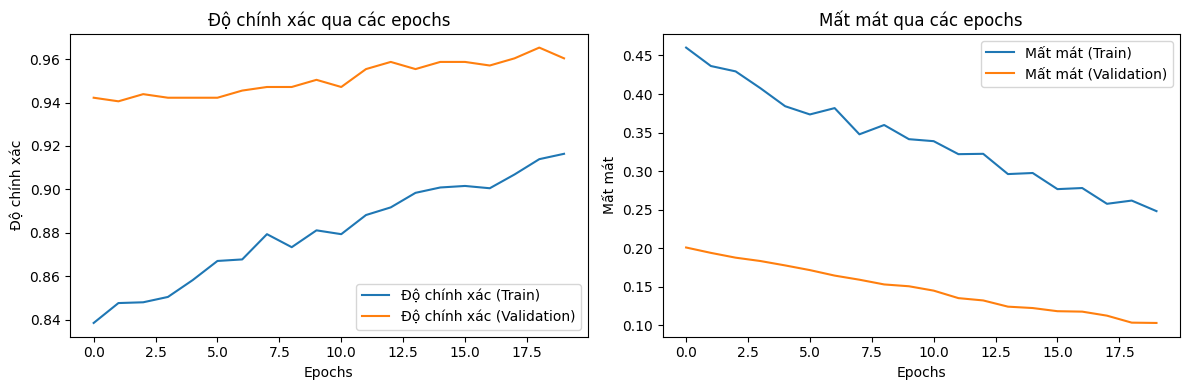

In [ ]:
# Vẽ biểu đồ độ chính xác
plt.figure(figsize=(12, 4))

# Đồ thị độ chính xác
plt.subplot(1, 2, 1)
plt.plot(history_fine_tune.history['accuracy'], label='Độ chính xác (Train)')
plt.plot(history_fine_tune.history['val_accuracy'], label='Độ chính xác (Validation)')
plt.title('Độ chính xác qua các epochs')
plt.xlabel('Epochs')
plt.ylabel('Độ chính xác')
plt.legend()

# Đồ thị mất mát
plt.subplot(1, 2, 2)
plt.plot(history_fine_tune.history['loss'], label='Mất mát (Train)')
plt.plot(history_fine_tune.history['val_loss'], label='Mất mát (Validation)')
plt.title('Mất mát qua các epochs')
plt.xlabel('Epochs')
plt.ylabel('Mất mát')
plt.legend()

plt.tight_layout()
plt.savefig('/content/gdrive/MyDrive/Essay/training_accuracy_lossDenseNet121v5.png')
plt.show()


In [ ]:
# Đánh giá mô hình trên tập test
test_loss, test_accuracy = model.evaluate(test_generator)  # Đánh giá mô hình trên tập test

# In ra độ chính xác
print("Test accuracy:", test_accuracy)


19/19 ━━━━━━━━━━━━━━━━━━━━ 101s 5s/step - accuracy: 0.9378 - loss: 0.1675
Test accuracy: 0.9506579041481018


In [ ]:
# Dự đoán trên tập test
test_generator.reset()  # Đảm bảo thứ tự chính xác của dữ liệu
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Chọn lớp có xác suất cao nhất

# Lấy nhãn thực tế từ tập test
y_true = test_generator.classes

# Tính toán các chỉ số
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# In kết quả
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# In Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred_classes))

# In Classification Report (bao gồm precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


19/19 ━━━━━━━━━━━━━━━━━━━━ 108s 5s/step
Accuracy: 0.9507
Precision: 0.9516
Recall: 0.9507
F1 Score: 0.9506
Confusion Matrix:
[[117   5   0   0   0]
 [  1 107  16   0   0]
 [  1   2 113   2   1]
 [  0   0   0 118   0]
 [  0   2   0   0 123]]

Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.98      0.96      0.97       122
            im_Koilocytotic       0.92      0.86      0.89       124
             im_Metaplastic       0.88      0.95      0.91       119
               im_Parabasal       0.98      1.00      0.99       118
im_Superficial-Intermediate       0.99      0.98      0.99       125

                   accuracy                           0.95       608
                  macro avg       0.95      0.95      0.95       608
               weighted avg       0.95      0.95      0.95       608



### 8. Vẽ Confusion Matrix

19/19 ━━━━━━━━━━━━━━━━━━━━ 102s 5s/step
Accuracy: 0.9507
Precision: 0.9516
Recall: 0.9507
F1 Score: 0.9506


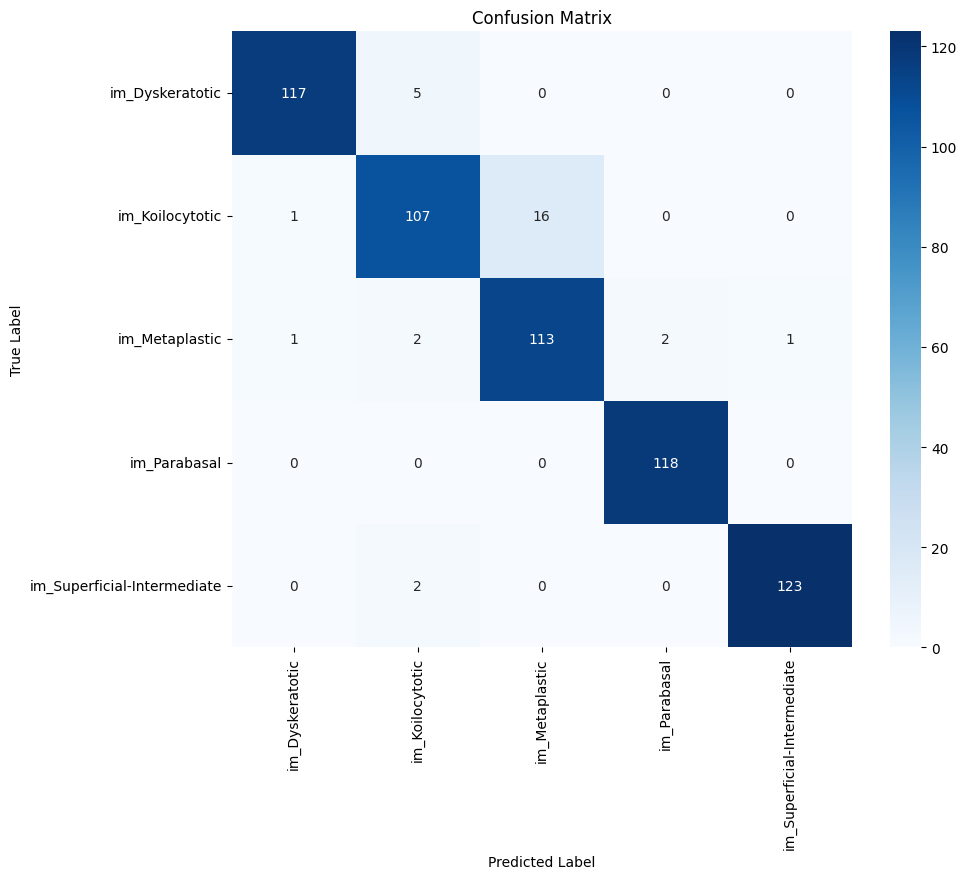


Classification Report:
                             precision    recall  f1-score   support

            im_Dyskeratotic       0.98      0.96      0.97       122
            im_Koilocytotic       0.92      0.86      0.89       124
             im_Metaplastic       0.88      0.95      0.91       119
               im_Parabasal       0.98      1.00      0.99       118
im_Superficial-Intermediate       0.99      0.98      0.99       125

                   accuracy                           0.95       608
                  macro avg       0.95      0.95      0.95       608
               weighted avg       0.95      0.95      0.95       608



In [ ]:
# Dự đoán trên tập test
test_generator.reset()  # Đảm bảo thứ tự chính xác của dữ liệu
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)  # Chọn lớp có xác suất cao nhất

# Lấy nhãn thực tế từ tập test
y_true = test_generator.classes

# Tính toán các chỉ số
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='weighted')
recall = recall_score(y_true, y_pred_classes, average='weighted')
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# In kết quả
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Tính toán và vẽ Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_generator.class_indices.keys(), yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")

# Lưu ảnh Confusion Matrix
plt.savefig("confusion_matrix_DenseNet121ver5.png", dpi=300, bbox_inches='tight')
plt.show()

# In Classification Report (bao gồm precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes, target_names=test_generator.class_indices.keys()))


### 9. Vẽ đường cong ROC

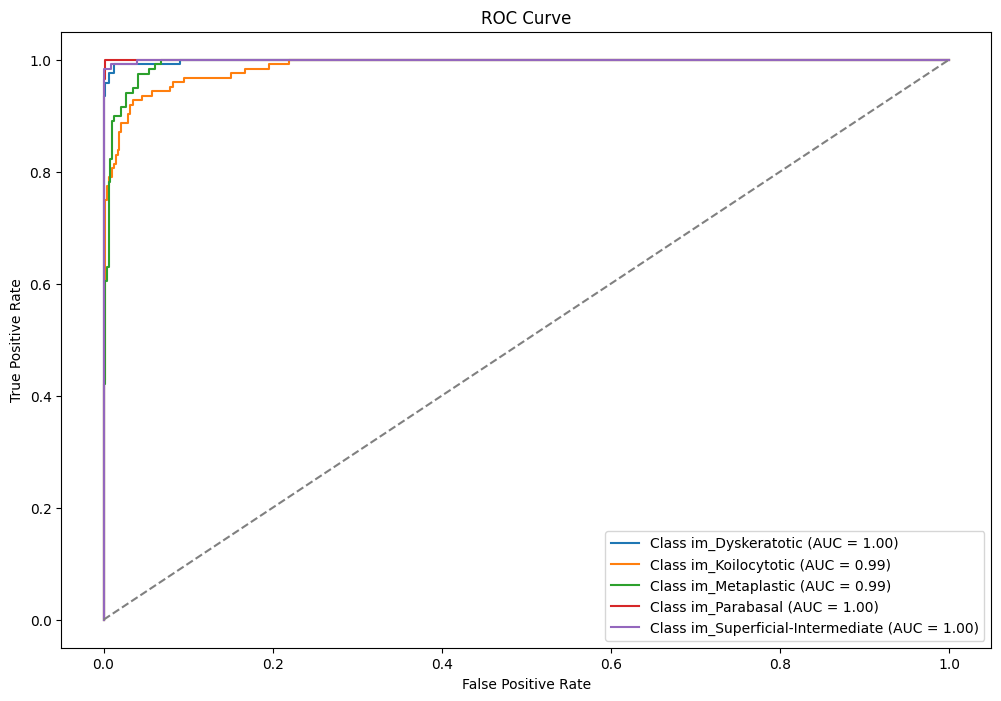

In [ ]:
# Chuyển đổi y_true sang định dạng nhị phân
n_classes = len(test_generator.class_indices)
y_true_binary = label_binarize(y_true, classes=range(n_classes))

# Vẽ ROC cho từng lớp
plt.figure(figsize=(12, 8))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_binary[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {list(test_generator.class_indices.keys())[i]} (AUC = {roc_auc:.2f})")

# Vẽ đường chéo
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")

# Định dạng biểu đồ
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

# Lưu ảnh vào Drive
plt.savefig("roc_auc_curve_DenseNet121ver5.png", dpi=300, bbox_inches='tight')
plt.show()
